In [1]:
import cv2
cv2.__version__

'4.5.4'

In [2]:
# import sample data
#from skimage.data import cells3d
from pathlib import Path
#import ndimage

import napari
from napari.settings import get_settings
import math


import statistics as st
import xlsxwriter

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pyvista as pv

import scipy
from scipy import ndimage as ndi

from skimage import io, filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import EllipseModel
from vispy.color import Colormap

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from csbdeep.utils import normalize
from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

from IPython.display import display_html, clear_output

from aicsimageio import AICSImage

2024-10-09 12:20:06.687231: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 12:20:06.687898: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 12:20:06.691042: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 12:20:06.728563: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 12:20:07.525824: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
# Get the AICSImage object
tiff_file='IF_2D_new_IF_2D_M1_5min_1.tif'
meta=AICSImage(tiff_file)
#img = io.imread(tiff_file)
#print(img.shape)
img = meta.get_image_data("XYZ", T=0) 
print(img.shape)

(1024, 1024, 3)


### Information about the staining

In [4]:
ch_color=['blue','red','green']
ch_marker=['DAPI','F4-80','CD80'] #S1

coord_order='YX'

In [5]:
r_X=meta.physical_pixel_sizes.X
r_Y=meta.physical_pixel_sizes.Y
print([r_X,r_Y])

[1.0251905771496683, 1.0251905771496683]


#### Functions

In [6]:
def non_proc(im_in):
    return im_in.copy()

def ln_trans(im_in):
    val_c = 255.0 / np.log(1.0 + np.max(im_in))
    im_out = (val_c * (np.log(im_in + 1.0))).astype(int)
    return im_out.copy()

def exp_trans(im_in,val_a):
    val_c = 255.0 / ((1.0 + val_a)**np.max(im_in) - 1.0)
    im_out = (val_c*((1.0 + val_a)**im_in - 1.0))
    return im_out.copy()

def gamma_trans(im_in,gamma):
    val_c = 255.0 / (np.max(im_in)**gamma)
    im_out = val_c*(im_in**gamma)
    return im_out.copy()

def hist_slide_inc(im_in,shift_in):
    lim=255-shift_in
    im_out[im_in > lim] = 255
    im_out[im_in <= lim] += shift_in
    return im_out.copy()

def hist_slide_dec(im_in,shift_dec):
    lim=shift_dec
    im_out[im_in < lim] = 0
    im_out[im_in >= lim] -= shift_dec
    return im_out.copy()

def cont_stretch(im_in):
    val_a, val_b = 0.0, 255.0
    val_c, val_d = im_in.min(), im_in.max()
    im_out=((im_in-val_c)*((val_b - val_a)/(val_d-val_c)) + val_a).astype(int)
    return im_out.copy()

def contr_limit(im_in,c_min,c_max):
    alpha = 255.0/(c_max - c_min)
    beta = - c_min * (alpha)
    im_out=(np.clip(alpha*im_in+beta, 0.0, 255.0)).astype(int)
    #print(np.max(im_out))
    return im_out.copy()
    
def histo_equal(im_in):
    h=im_in.shape[1]
    w=1 #im_in.shape[2]
    r=im_in.shape[0]

    tot_pixs=h*w*r

    levels=256

    im_hist = np.zeros((levels))

    for i in range(0,levels):
        im_hist[i] = np.count_nonzero(im_in == i)

    pdf = np.zeros((levels))
    for i in range(0,levels):
        pdf[i] = im_hist[i]/tot_pixs

    cdf = np.zeros((levels))
    cdf[0] = pdf[0]
    for i in range(1, levels):
        cdf[i] = pdf[i] + cdf[i-1]

    im_out=im_in.copy()
        
    for u in range(0,r):
        for j in range(0,h):
            for k in range(0,w):
                im_out[u,j] = int(round((levels-1) * cdf[im_in[u,j]]))
    return im_out.copy()

## MULTIPLE TRANSFORM

##### [options: non_proc(im_in), ln_trans(im_in), exp_trans(im_in,val_a), gamma_trans(im_in,gamma), hist_slide_inc(im_in,shift_in), hist_slide_dec(im_in,shift_dec), cont_stretch(im_in), histo_equal(im_in)]

In [7]:
trig_show_original=True
trig_remove_noise=True
trig_transform=True
trig_filter=False
trig_threshold=True
trig_watershed=True
trig_stardist=True
trig_vtk_creation=True
trig_stl_creation=True

In [8]:
if trig_show_original:
    viewer_0 = napari.Viewer()
    for c, c_name in enumerate(ch_marker):
        im_in=meta.get_image_data(coord_order, Z=c, C=0, S=0, T=0)
        #im_in=im_in[:1000,:1000]
        im_in=(im_in/256.0).astype('uint8')
        
        viewer_0.add_image(im_in, name=c_name, 
                            colormap=ch_color[c], blending='additive')

libGL error: glx: failed to create dri3 screen
libGL error: failed to load driver: nouveau


##### Test the function for histogram transformation here

In [9]:
viewer_0 = napari.Viewer()
for c, c_name in enumerate(ch_marker):
    im_in=meta.get_image_data(coord_order, Z=c, C=0, S=0, T=0)
    #im_in=im_in[1728:2628,2332:3132]
    im_in=(im_in/256.0).astype('uint8') 

    im_out=im_in.copy()
    print_im=im_out.copy()

    # REMOVE NOISE
    im_in=im_out.copy()
    
    if trig_remove_noise:
        im_out=filters.median(im_in)

        print_im_0=im_out.copy()
            
    # #FILTERING
    im_in=im_out.copy()
        
    if trig_filter:
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        
    print_im_0=im_out.copy()

    #HISTOGRAM TRANSFORMATION
    im_in=im_out.copy()

    if trig_transform:

        #func_list=[non_proc(im_in),contr_limit(im_in,5.0,100.0),contr_limit(im_in,5.0,20.0),non_proc(im_in)]
        func_list=[non_proc(im_in),non_proc(im_in),non_proc(im_in)]

        im_out=func_list[c]
        im_trans=im_out.copy()
        print_im=im_out.copy()

    #NAPARI UPLOAD
    viewer_0.add_image(print_im, name=c_name, 
                        colormap=ch_color[c], blending='additive')

    viewer_0.scale_bar.visible=True
    viewer_0.scale_bar.unit='um'

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.


2024-10-09 12:20:12.555453: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-09 12:20:12.555484: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: 7d489e710616
2024-10-09 12:20:12.555492: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: 7d489e710616
2024-10-09 12:20:12.555835: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.183.1
2024-10-09 12:20:12.555854: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.183.1
2024-10-09 12:20:12.555858: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.183.1


Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


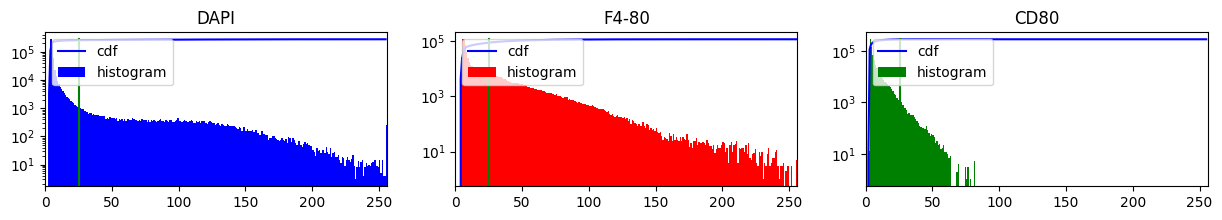

In [10]:
viewer_0 = napari.Viewer()
#viewer_1 = napari.Viewer()

train_scale=[r_X,r_Y]
train_factor=[1.0,1.0]

fig, axs = plt.subplots(1,3,figsize=(15,2))

for c, c_name in enumerate(ch_marker):
    im_in=meta.get_image_data(coord_order, Z=c, C=0, S=0, T=0)
    #im_in=im_in[39:939,96:896]
    im_in=(im_in/256.0).astype('uint8') 

    im_out=im_in.copy()
    print_im=im_out.copy()

    # REMOVE NOISE
    im_in=im_out.copy()
    
    if trig_remove_noise:
        im_out=filters.median(im_in)

        print_im=im_out.copy()
        
    #FILTERING
    im_in=im_out.copy()
    
    if trig_filter:
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        
        print_im=im_out.copy()

    #HISTOGRAM TRANSFORMATION
    im_in=im_out.copy()

    if trig_transform:

        #func_list=[non_proc(im_in),contr_limit(im_in,5.0,100.0),contr_limit(im_in,5.0,20.0),non_proc(im_in)]
        func_list=[non_proc(im_in),non_proc(im_in),non_proc(im_in)]

        im_out=func_list[c]
        im_trans=im_out.copy()
        print_im=im_out.copy()

    #THRESHOLDING
    im_in=im_out.copy()
    
    if trig_threshold:
        # nda=sitk.GetImageFromArray(im_in)
        
        # otsu_filter = sitk.OtsuThresholdImageFilter()
        # otsu_filter.SetInsideValue(0)
        # otsu_filter.SetOutsideValue(200)
        # seg = otsu_filter.Execute(nda)

        # val=otsu_filter.GetThreshold()
        # #print(val)
        
        # im_th=sitk.GetArrayFromImage(seg)

        imax=255 #np.max(im_in)
        imin=0 #np.min(im_in)

        val=(imax-imin)*0.1
        
        im_th=(im_in>val)*200.0

    else:
        im_th=im_in.copy()

    im_out=im_th.copy()
    print_im_1=im_th.copy()

    #FILTERING
    im_in=im_out.copy()
    
    if (trig_threshold & trig_filter):
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        im_out=im_out.astype('uint8')
        
        print_im_0=im_out.copy()

    #WATERSHED
    im_in=im_out.copy()
    #im_th=im_out.copy()

    labels=im_th.copy()
    im_labels=im_trans.copy()
    
    if trig_watershed and c_name=='DAPI':
        if trig_stardist:
            model = StarDist2D.from_pretrained('2D_versatile_fluo')
            img_te = normalize(im_labels,1.0,99.8)
            #labels, _ = model.predict_instances(img_te,prob_thresh=0.7, nms_thresh=0.2)
            #labels, _ = model.predict_instances(img_te)
            labels, _ = model.predict_instances(img_te,scale=(train_scale[0],train_scale[1]),prob_thresh=0.7, nms_thresh=0.2)
            im_mask=im_th/np.max(im_th)
            im_mask=ndi.binary_erosion(im_mask,structure=np.ones((2,2))).astype(im_mask.dtype)
            im_positive=labels*(im_mask)
            list_positive=list(np.unique(im_positive))
            list_positive=list_positive[1:]
            #print(list_positive)
        else:
            distance = ndi.distance_transform_edt(im_th_filt)
            coords = peak_local_max(distance, footprint=np.ones((3,3)), labels=im_th_filt.astype('uint8'))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = ndi.label(mask)
            labels = watershed(-distance, markers, mask=im_th_filt)

        cm=np.random.rand(int(np.max(labels)),3)
        cm[0,:]=[0.0,0.0,0.0]
        colormaps_water=Colormap(cm)

        print_im_water=labels.copy()

        viewer_0.add_image(print_im_water, name=c_name, scale=(r_X,r_Y),
                        colormap=colormaps_water, blending='additive')

    globals()[c_name+'lab']=labels.copy()
    globals()[c_name+'mag']=im_labels.copy()

    #NAPARI UPLOAD
    viewer_0.add_image(print_im_1, name=c_name, scale=(r_X,r_Y),
                        colormap=ch_color[c], blending='additive')

    viewer_0.scale_bar.visible=True
    viewer_0.scale_bar.unit='um'
    # viewer_1.scale_bar.visible=True
    # viewer_1.scale_bar.unit='um'

    #print(np.shape(labels))
    #print(np.shape(im_mask))


    #HISTOGRAM PLOTTING
    hist,bins = np.histogram(im_trans.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf* hist.max()/ cdf.max()

    axs[c].plot(cdf_normalized, color = 'b')
    if ch_color[c]=='white':
        axs[c].hist(im_trans.flatten(),256,[0,256], color = 'gray')
    else:
        axs[c].hist(im_trans.flatten(),256,[0,256], color = ch_color[c])
    axs[c].set_xlim([0,256])
    #axs[c].set_ylim([0,100])
    axs[c].legend(('cdf','histogram'), loc = 'upper left')
    if trig_threshold:
        axs[c].plot([val,val],[0,cdf_normalized.max()],color='g')
    axs[c].set_title(c_name)
    axs[c].set_yscale('log')

## Eccentricity analysis

In [11]:
cyto_marker='F4-80'
cyto_pos=ch_marker.index(cyto_marker)
#print(cyto_pos)

#im_cyto=meta.get_image_data(coord_order, Z=cyto_pos, C=0, S=0, T=0)
im_cyto=globals()[cyto_marker+'lab']

In [12]:
dil_kernel = np.ones((3, 3), np.uint8)

nuclei=DAPIlab.copy()
cyto=0.0+(im_cyto+nuclei)>0

overl=nuclei*cyto

#cyto=((overl-1.0)+cyto)+1.0

complete=False
k=0

#cm=np.random.rand(1000,3)
cm[0,:]=[0.0,0.0,0.0]
colormaps_rand=Colormap(cm)

list_nuclei=list(np.unique(DAPIlab)[1:])
list_cyto=list_nuclei.copy()

final_overl=np.zeros(overl.shape)
old_mask_ex=np.zeros(overl.shape)

for j in list_nuclei:
    complete=False
    cyto_overl=(overl==j)*1.0
    if np.isin(j, list_cyto):
        k=0
        #print(j)
        while not complete:
            ex_cyto=cv.dilate(cyto_overl,dil_kernel)
            mask_ex_cyto=(ex_cyto*(cyto==1.0))
            if (len(np.unique(mask_ex_cyto*nuclei))<3):
                #print(np.unique(mask_ex_cyto*nuclei))
                cyto_overl=mask_ex_cyto
            else:
                list_cyto.remove(j)
                complete=True
                cyto_overl=np.zeros(overl.shape)
            if (k>20) or (np.all(old_mask_ex==mask_ex_cyto)):
                complete=True
            k+=1
            old_mask_ex=mask_ex_cyto
        final_overl=final_overl+cyto_overl*j

overl_mask=np.isin(final_overl,list_cyto)
final_overl[~overl_mask]=0
overl=final_overl

In [13]:
viewer_0 = napari.Viewer()

viewer_0.add_image(nuclei, name='DAPI', 
    colormap='blue', blending='additive')
viewer_0.add_image(globals()[cyto_marker+'mag'], name='BF', 
    colormap='white', blending='additive')
viewer_0.add_image(overl, name='Cyto', 
    colormap='red', blending='additive')

<Image layer 'Cyto' at 0x7b2ebb593310>

### Check eccentricity of cells

In [14]:
viewer_1 = napari.Viewer()
mat_ecc=np.zeros(overl.shape)
shapepoints=[]
shapepoints_glob=[]
shape_cm=np.zeros((len(list_cyto)+1,3))
elpoints=np.array([[0,0],[0,0],[0,0],[0,0]])
shapepoints.append(elpoints)
shapepoints_glob.append(elpoints)
step_colormap=len(cm)/int(np.max(DAPIlab))

data_ellipse_x=[]
data_ellipse_y=[]
data_ellipse_a=[]
data_ellipse_b=[]
data_ellipse_theta=[]
data_ellipse_area=[]
data_ellipse_ecc=[]

for j,v in enumerate(list_cyto):
    points=[]
    shape_cm[j,:]=cm[math.floor(step_colormap*(j))]
    x,y=np.where(overl==v)
    for c,cx in enumerate(x):
        points=points+[(cx,y[c])]

    a_points = np.array(points)
        
    ell = EllipseModel()
    ell.estimate(a_points)

    xcen, ycen, a, b, theta = ell.params

    area=np.pi*a*b

    if area*(r_X*r_X)>150: #um2

        data_ellipse_x.append(xcen)
        data_ellipse_y.append(ycen)
        data_ellipse_a.append(a)
        data_ellipse_b.append(b)
        data_ellipse_theta.append(theta)
        data_ellipse_area.append(area)

        ecc=np.min([a,b])/np.max([a,b])
        data_ellipse_ecc.append(ecc)  
    
        pA=[xcen+a*np.cos(theta)-b*np.sin(theta),ycen+b*np.cos(theta)+a*np.sin(theta)]
        pB=[xcen-a*np.cos(theta)-b*np.sin(theta),ycen+b*np.cos(theta)-a*np.sin(theta)]
        pC=[xcen-a*np.cos(theta)+b*np.sin(theta),ycen-b*np.cos(theta)-a*np.sin(theta)]
        pD=[xcen+a*np.cos(theta)+b*np.sin(theta),ycen-b*np.cos(theta)+a*np.sin(theta)]

        elpoints=np.array([pA,pB,pC,pD])
        shapepoints.append(elpoints)

        xcen=0.0
        ycen=0.0

        pA=[xcen+a*np.cos(theta)-b*np.sin(theta),ycen+b*np.cos(theta)+a*np.sin(theta)]
        pB=[xcen-a*np.cos(theta)-b*np.sin(theta),ycen+b*np.cos(theta)-a*np.sin(theta)]
        pC=[xcen-a*np.cos(theta)+b*np.sin(theta),ycen-b*np.cos(theta)-a*np.sin(theta)]
        pD=[xcen+a*np.cos(theta)+b*np.sin(theta),ycen-b*np.cos(theta)+a*np.sin(theta)]

        elpoints=np.array([pA,pB,pC,pD])
        shapepoints_glob.append(elpoints)

#viewer_0 = napari.Viewer()

colormaps_shapes_rand=Colormap(shape_cm)
viewer_0.add_shapes(shapepoints, name='ellipses', shape_type='ellipse', 
    face_color=cm, blending='additive')

viewer_1.add_shapes(shapepoints_glob, name='cumulative ellipses', shape_type='ellipse', 
    face_color=cm, blending='additive')

color_transformations.py (53): The provided face_color parameter has 516 entries, while the data contains 120 entries. Setting face_color to white.
color_transformations.py (53): The provided face_color parameter has 516 entries, while the data contains 120 entries. Setting face_color to white.


<Shapes layer 'cumulative ellipses' at 0x7b2ebabdbe50>

## Quantification nuclei marker

In [15]:
ch_marker_2=ch_marker.copy()
ch_color_2=ch_color.copy()
ch_marker_2.remove('DAPI')
#ch_marker_2.remove('BF')
ch_color_2.remove('blue')
#ch_color_2.remove('white')

viewer_0 = napari.Viewer()
nuc_coord=np.zeros((int(np.max(DAPIlab))+1,2))
coord_done=False
#viewer_1 = napari.Viewer()
for c, channel in enumerate(ch_marker_2):
    ass_channel=np.zeros(DAPIlab.shape)
    globals()[channel+'pos']=[]
    globals()[channel+'coord']=np.zeros((int(np.max(DAPIlab))+1,2))
    #ass_channel_2=np.zeros(DAPIlab.shape)
    for j in range(1,int(np.max(DAPIlab))+1):
        if coord_done==False:
            x,y=np.where(DAPIlab==j)
            c_area=np.sum(DAPIlab==j)
            nuc_coord[j,0]=np.mean(x)*globals()['r_'+coord_order[0]]
            nuc_coord[j,1]=np.mean(y)*globals()['r_'+coord_order[1]]
        if np.sum(globals()[channel+'lab']*(DAPIlab==j)/np.max(globals()[channel+'lab']))>(c_area/2):
            ass_channel=ass_channel+(DAPIlab==j)*1.0
            globals()[channel+'coord'][j,0]=nuc_coord[j,0]
            globals()[channel+'coord'][j,1]=nuc_coord[j,1]          
            globals()[channel+'pos'].append(j)
        #ass_channel_2=ass_channel_2+globals()[channel+'mag']*(DAPIlab==j)/np.max(globals()[channel+'mag'])
        #print(np.max(DAPIlab))
    coord_done=True

    viewer_0.add_image(ass_channel, name=channel, 
        colormap=ch_color_2[c], blending='additive')
    # viewer_1.add_image(ass_channel_2, name=channel, 
    #     colormap=colormaps[c+1], blending='additive')
        

## QUANTIFICATION

TOTAL NUCLEI 517
PERC F4-80 91.8762088974855 %
PERC F4-80 + CD80 15.667311411992262 %
PERC CD80 17.02127659574468 %


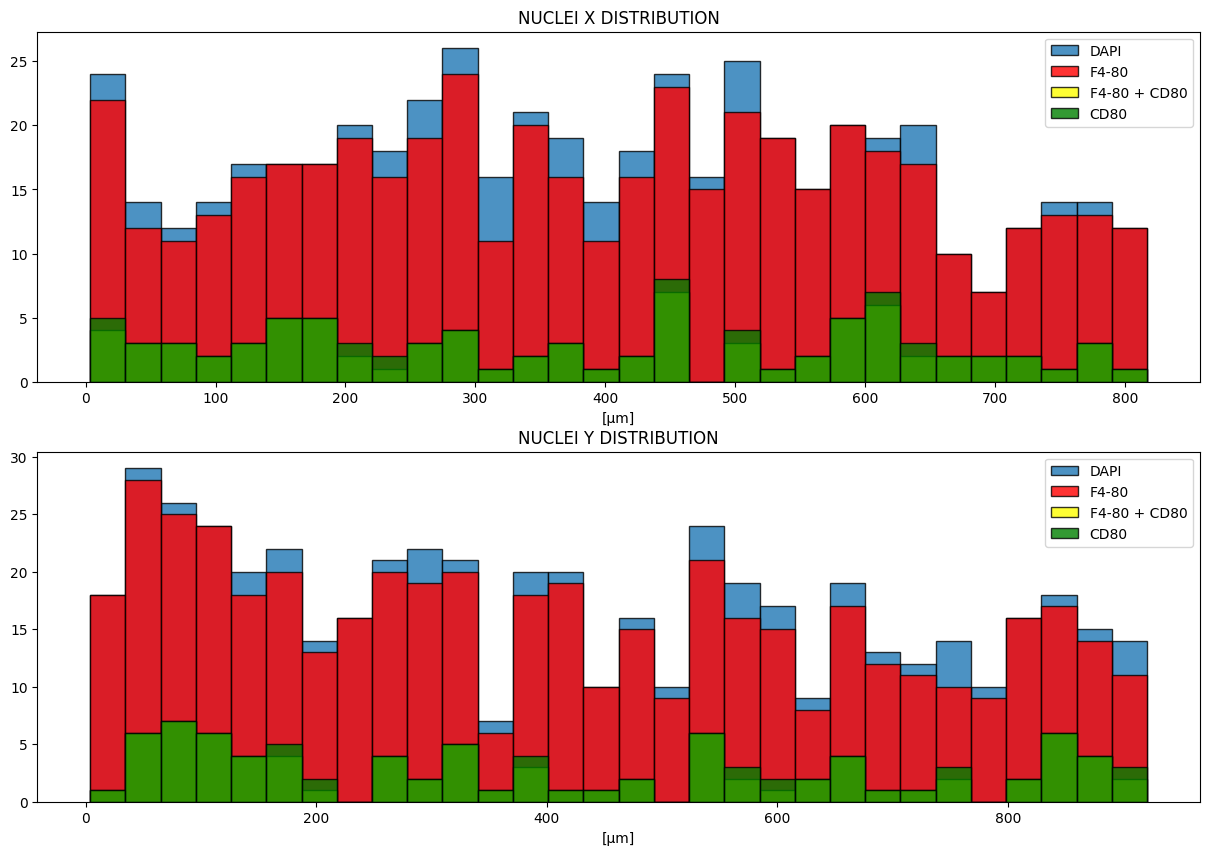

In [16]:
print('TOTAL NUCLEI ' + str(np.max(DAPIlab)+1))
for c, channel in enumerate(ch_marker_2):
    print('PERC ' + channel + ' ' + str(100.0 * len(globals()[channel + 'pos'])/(np.max(DAPIlab)+1)) + ' %')
    for c2, channel2 in enumerate(ch_marker_2[c+1:]):
        print('PERC ' + channel + ' + ' + channel2 + ' ' + str(100.0 * len(list(set(globals()[channel+ 'pos']).intersection(globals()[channel2 + 'pos'])))/(np.max(DAPIlab)+1)) + ' %')
fig, axs = plt.subplots(2,1,figsize=(15,10))
leg=[]
axs[0].hist(nuc_coord[1:,coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),alpha=0.8,edgecolor='black')
for c, channel in enumerate(ch_marker_2):
    axs[0].hist(globals()[channel+'coord'][globals()[channel + 'pos'],coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),alpha=0.8,color=ch_color_2[c],edgecolor='black')
    leg=leg+[str(channel)]
    for c2, channel2 in enumerate(ch_marker_2[c+1:]):
        axs[0].hist(globals()[channel+'coord'][list(set(globals()[channel+ 'pos']).intersection(globals()[channel2 + 'pos'])),coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),alpha=0.8,color='yellow',edgecolor='black')
        #print('PERC ' + channel + ' + ' + channel2 + ' ' + str(100.0 * len(list(set(globals()[channel+ 'pos']).intersection(globals()[channel2 + 'pos'])))/np.max(DAPIlab)+1) + ' %')
        leg=leg+[str(channel + ' + ' + channel2)]
axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[0].legend(['DAPI']+leg, loc='upper right')
axs[1].hist(nuc_coord[1:,coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),alpha=0.8,edgecolor='black')
for c, channel in enumerate(ch_marker_2):
    axs[1].hist(globals()[channel+'coord'][globals()[channel + 'pos'],coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),alpha=0.8,color=ch_color_2[c],edgecolor='black')
    for c2, channel2 in enumerate(ch_marker_2[c+1:]):
        axs[1].hist(globals()[channel+'coord'][list(set(globals()[channel+ 'pos']).intersection(globals()[channel2 + 'pos'])),coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),alpha=0.8,color='yellow',edgecolor='black')
        #print('PERC ' + channel + ' + ' + channel2 + ' ' + str(100.0 * len(list(set(globals()[channel+ 'pos']).intersection(globals()[channel2 + 'pos'])))/np.max(DAPIlab)+1) + ' %')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
axs[1].legend(['DAPI']+leg, loc='upper right')
plt.show()

#### Eccentricity

AVG ECCENTRICITY 0.6449013916392735
STDEV ECCENTRICITY 0.17247103463180444


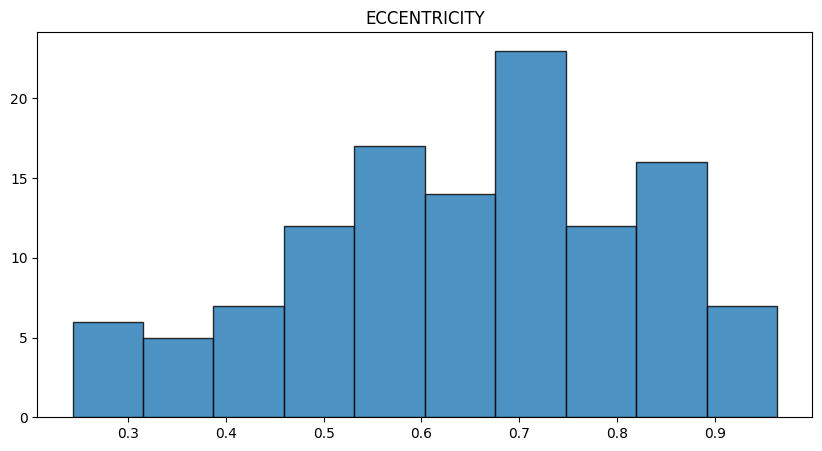

In [17]:
print('AVG ECCENTRICITY ' + str(np.mean(data_ellipse_ecc)))
print('STDEV ECCENTRICITY ' + str(np.std(data_ellipse_ecc)))
fig, axs = plt.subplots(1,1,figsize=(10,5))
axs.hist(data_ellipse_ecc,bins=10,range=(min(data_ellipse_ecc),max(data_ellipse_ecc)),alpha=0.8,edgecolor='black')
axs.set_title('ECCENTRICITY')
fig.savefig("plot_eccent.svg")

### Create a complete report XSL

In [42]:
workbook=xlsxwriter.Workbook(Path(tiff_file).stem+'.xlsx')

## FORMATS
header=workbook.add_format({'bg_color':'blue','bold':True})
#header.set_bg_color('yellow')
floats=workbook.add_format({'num_format':'0.00'})
percs=workbook.add_format({'num_format':'0.00%'})
text=workbook.add_format({'num_format':'@'})

## MACROPHAGES TAB
worksheet_cell=workbook.add_worksheet('Macrophages')

#HEADER
worksheet_cell.write_row('A1:C1',['#ID','X','Y'],header)
column=3
for c, channel in enumerate(ch_marker_2):
    header=workbook.add_format({'bg_color':ch_color_2[c],'bold':True})
    worksheet_cell.write(0,column,channel,header)
    column+=1
    for c2, channel2 in enumerate(ch_marker_2[c+1:]):
        header=workbook.add_format({'bg_color':'yellow','bold':True})
        worksheet_cell.write(0,column,channel + ' + ' + channel2 ,header)
        column+=1        
    
#CONTENT
for row in range(1,int(np.max(DAPIlab))+1):
    worksheet_cell.write(row,0,row)
    worksheet_cell.write(row,1,nuc_coord[row][coord_order.find('X')],floats)
    worksheet_cell.write(row,2,nuc_coord[row][coord_order.find('Y')],floats)
    column=3
    for c, channel in enumerate(ch_marker_2):
        ass_channel=(globals()[channel+'lab']*(DAPIlab==row)/np.max(globals()[channel+'lab']))>0
        worksheet_cell.write(row,column,(np.sum(ass_channel)>0).astype('bool'),text)
        column+=1
        for c2, channel2 in enumerate(ch_marker_2[c+1:]):
            ass_channel=(globals()[channel+'lab']*(DAPIlab==row)/np.max(globals()[channel+'lab']))>0
            ass_channel2=(globals()[channel2+'lab']*(DAPIlab==row)/np.max(globals()[channel2+'lab']))>0
            worksheet_cell.write(row,column,((np.sum(ass_channel)>0)and(np.sum(ass_channel2)>0)).astype('bool'),text)
            column+=1 

## RECAP TAB
worksheet_recap=workbook.add_worksheet('Recap')

#CONTENT
worksheet_recap.write_row('A1:A2',['Tot. cells',np.max(DAPIlab)+1])
row=1
for c, channel in enumerate(ch_marker_2):
    worksheet_recap.write(row,0,'PERC ' + channel,text)
    worksheet_recap.write(row,1,len(globals()[channel + 'pos'])/(np.max(DAPIlab)+1),percs) 
    row+=1
    for c2, channel2 in enumerate(ch_marker_2[c+1:]):
        worksheet_recap.write(row,0,'PERC ' + channel + ' + ' + channel2,text)
        worksheet_recap.write(row,1,len(list(set(globals()[channel+ 'pos']).intersection(globals()[channel2 + 'pos'])))/(np.max(DAPIlab)+1),percs) 
        row+=1


workbook.close()